<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
EM-Algorithm for GMMs - Detailed Visualization and Playground
</h1>

Second accompanying notebook for the lecture slides:

  * Christian Bauckhage: "Lectures on Pattern Recognition", Add-on to Lecture 14: "Expectation Maximization for Gaussian Mixture Models", December 2017 ([Download from ReseachGate](https://www.researchgate.net/project/lectures-on-pattern-recognition/update/5a3e23734cde266d587d382f))
  * Based on Lecture 14: "Expectation Maximization, Gaussian Models for Classification, and Discriminant Analysis Techniques", December 2017 ([Download from ReseachGate](https://www.researchgate.net/project/lectures-on-pattern-recognition/update/5a36659ab53d2f0bba44f06f))

In the notebook "Expectation Maximization for Gaussian Mixture Model" we presented the model you can find in the slides. In this notebook we add two more aspects:

  * A more detailed visualization supporting a deeper understanding of the alogrithm.
  * The task to challenge the algorithm to expose its flaws, so that you learn to use it wisely.

Both aspects are meant to give you a more immediate understanding of the algorithm. You may as well realize what the maths tells you that experimenting does not tell you as easily.

<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd

import matplotlib.pyplot as plt

from functools import partial

## Plotting utilities

In [2]:
def plot_axes(axs, lims):
    axs.set_aspect(aspect='equal')
    axs.spines['left'].set_position('zero')
    axs.spines['left'].set_zorder(1)
    axs.spines['bottom'].set_position('zero')
    axs.spines['bottom'].set_zorder(1)
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.tick_params(direction='out')
    axs.set_xlim(lims[0],lims[1])
    axs.set_ylim(lims[2],lims[3])

def plot_means(axs, M, alpha=0.75):
    axs.plot(M[:, 0], M[:, 1], 'bo', ms=7, alpha=alpha)

def plot_data(axs, X, C, alpha=0.25, scale=False):
    if C is None:
        axs.plot(X[:, 0], X[:, 1], 'o', color='k', ms=7, alpha=alpha)
        return 
    im = axs.scatter(X[:, 0], X[:, 1], c=C, cmap='PRGn', vmin = 0, alpha=alpha)
    if scale:
        axs.get_figure().colorbar(im, ax=axs)

def plot_model(axs, model, alpha=0.75):
    X, Y, Z = model
    axs.contour(X, Y, Z, 17, cmap='viridis', alpha=alpha)

def init_plots(n, lims, title=None):
    f, [axs] = plt.subplots(1, n, figsize = (18, min(6, 18/n)), squeeze=False)
    for a in axs: plot_axes(a, lims)
    if title: f.suptitle(title, fontsize='x-large', x=0.12, ha='left')
    return axs[0] if len(axs) == 1 else axs

def done_plots():
    plt.show()
    plt.close()
    
def find_limits(X):
    xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
    ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
    return [xmin, xmax, ymin, ymax]

def grid_and_points(limits):
    dx = limits[1] - limits[0]
    dy = limits[3] - limits[2]
    nx = 50; ny = int(nx * dy/dx)
    xs, ys = np.meshgrid(np.linspace(lims[0], lims[1], nx), np.linspace(lims[2], lims[3], ny))
    return xs, ys, np.dstack((xs, ys))

##  Distributions

**Multivariate Gaussian Distribution / Multivariate Normal Distribution**

$$  \mathcal{N}({\mathbf x}\mid \boldsymbol\mu,\, \boldsymbol\Sigma) = {\det(2\pi \boldsymbol\Sigma)}^{- \frac 1 2} \exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)$$

In [3]:
def gaussian_pdf(X, m, S):
    Inv = la.inv(S)
    nrm = 1 / np.sqrt(la.det(2*np.pi*S))
    D = X - m
    p = np.sum(np.multiply(np.dot(D, Inv), D), axis=-1)
    return nrm * np.exp(-0.5 * p)

**Gaussian Mixture Distribution**

$$ p({\mathbf x} \mid \mathcal{w}_1, \boldsymbol\mu_1,\, \boldsymbol\Sigma_1 \ldots \mathcal{w}_k, \boldsymbol\mu_k,\, \boldsymbol\Sigma_k ) = \sum_{i=1}^k \mathcal{w}_i \: \mathcal{N}({\mathbf x}\mid \boldsymbol\mu_i,\, \boldsymbol\Sigma_i) $$

In [4]:
def gaussian_mixture_pdf(X, ws, Ms, Ss):
    k = len(ws)
    p = np.zeros(X.shape[:-1])
    for i in range(k):
        p += ws[i] * gaussian_pdf(X, Ms[i, :], Ss[i, :, :])
    return p

## Sampling a Gaussian Mixture

In [5]:
def gaussian_mixture_sample(ws, Ms, Ss, n):
    k = len(ws)
    ns = rnd.multinomial(n, ws)
    X = [rnd.multivariate_normal(Ms[i], Ss[i], ns[i]) for i in range(k)]
    X = np.vstack(X)
    rnd.shuffle(X)
    return X

In [6]:
sample_weights = np.array([3/16, 5/16, 8/16])
sample_means = np.array([[0, 1], [5, 2], [1, 6]])
sample_covariances = np.array([[[0.5, 0.1], [0.1, 0.5]], [[1.0, 1.5], [1.5, 4.0]], [[3.0, 0.0], [0.0, 1.0]]])

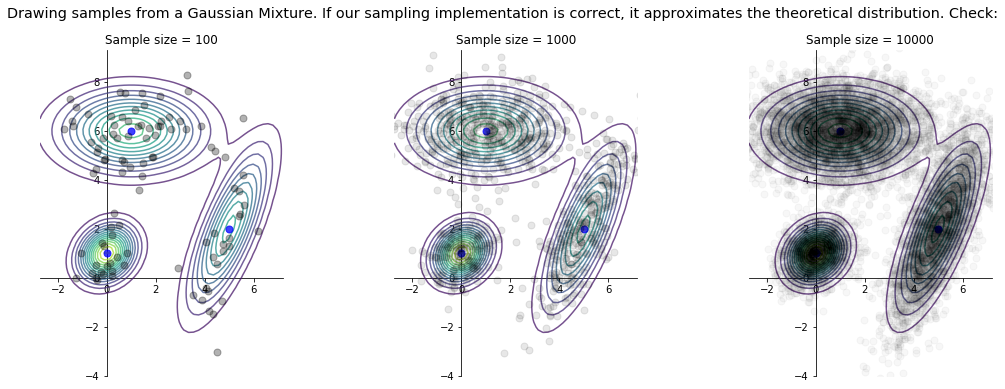

In [7]:
sizes = [10**i for i in range(2, 5)]
X = [gaussian_mixture_sample(sample_weights, sample_means, sample_covariances, size) for size in sizes]

lims = find_limits(X[0])
xs, ys, xys = grid_and_points(lims)

axs = init_plots(len(sizes), lims, title='Drawing samples from a Gaussian Mixture. ' + 
                 'If our sampling implementation is correct, it approximates the theoretical distribution. Check:')

for i, size in enumerate(sizes):
    axs[i].set_title('Sample size = ' + str(size))
    plot_model(axs[i], (xs, ys, gaussian_mixture_pdf(xys, sample_weights, sample_means, sample_covariances)))
    plot_means(axs[i], sample_means)
    plot_data(axs[i], X[i], None, alpha=3/np.sqrt(size))

done_plots()

## Expectation Maximization for Gaussian Mixture Models

### E-Step

Equation (7) in the slides tells us to set the new probabilty of the $j$-th point being chosen from the $i$-th component of the Gaussian mixture to its relative probabilty from the $i$-th component given the other parameters.

$$ 
\zeta_{ij} \: = \:
\frac{
\mathcal{w}_i \: \mathcal{N}({\mathbf x}_j \mid \boldsymbol\mu_i,\, \boldsymbol\Sigma_i)
}{
\sum_{l=1}^k \mathcal{w}_l \: \mathcal{N}({\mathbf x}_j\mid \boldsymbol\mu_l,\, \boldsymbol\Sigma_l)
}
$$

### M-Step
The equations (8), (9), and (10) in the slides tell us to set the mean, the covariance and the weight of the $i$-th component of the Gaussian mixture to the "empirical" mean, covariance and weight weighted by the given mixture probabilities.

$$ 
\mu_i \: = \:
\frac{
\sum_{j} \zeta_{ij} {\mathbf x}_j
}{
\sum_{j} \zeta_{ij}
}
, \qquad
\Sigma_i \: = \:
\frac{
\sum_{j} \zeta_{ij} ({\mathbf x}_j - \mu_i)({\mathbf x}_j - \mu_i)^T
}{
\sum_{j} \zeta_{ij}
}
, \qquad
\mathcal{w}_i \: = \:
\frac{
\sum_{j} \zeta_{ij}
}{
n
}
$$

In [8]:
def gmm_expectation_maximization(X, T, M, show=lambda state, t, i, Z, w, M, S: None):

    n, m = X.shape
    k = M.shape[0]

    w = np.ones(k)/ k
    S = np.array([np.identity(m) for i in range(k)])
    Z = np.zeros((k, n))

    for t in range(T):
        _                                                                      ; show('E-Step',   t, -1, Z, w, M, S)
        for i in range(k):
            Z[i] = w[i] * gaussian_pdf(X, M[i], S[i])                          ; show('E-Step i', t,  i, Z, w, M, S)
        Z /= np.sum(Z, axis=0)                                                 ; show('E-Step k', t,  k, Z, w, M, S)
        _                                                                      ; show('M-Step',   t, -1, Z, w, M, S)
        
        for i in range(k):
            D = X - M[i]
            M[i] =  Z[i].T.dot(X)      / np.sum(Z[i])
            S[i] = (Z[i] * D.T).dot(D) / np.sum(Z[i])
            w[i] = np.sum(Z[i]) / n                                            ; show('M-Step i', t,  i, Z, w, M, S)
    _                                                                          ; show('done',     t, -1, Z, w, M, S)
    return w, M, S

### Example

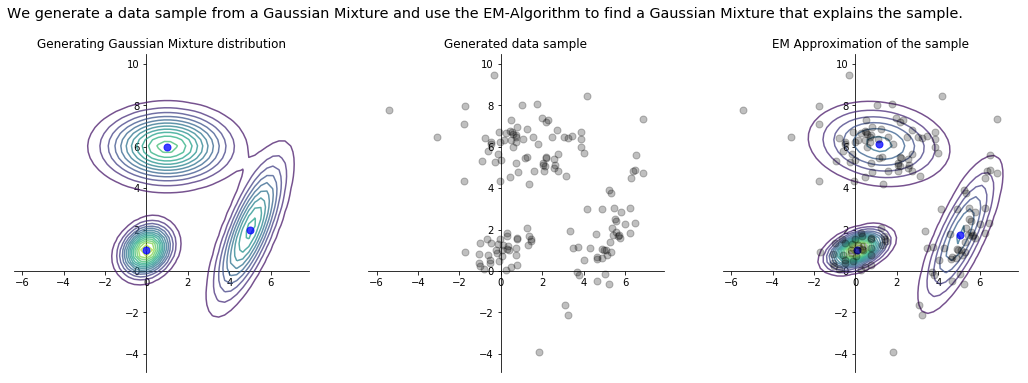

In [9]:
X = gaussian_mixture_sample(sample_weights, sample_means, sample_covariances, 150)

lims = find_limits(X); xs, ys, xys = grid_and_points(lims)
axs = init_plots(3, lims, title='We generate a data sample from a Gaussian Mixture ' + 
                 'and use the EM-Algorithm to find a Gaussian Mixture that explains the sample.')

axs[0].set_title('Generating Gaussian Mixture distribution')
plot_model(axs[0], (xs, ys, gaussian_mixture_pdf(xys, sample_weights, sample_means, sample_covariances)))
plot_means(axs[0], sample_means)

axs[1].set_title('Generated data sample')
plot_data(axs[1], X, None)

axs[2].set_title('EM Approximation of the sample')
w, M, S = gmm_expectation_maximization(X, 5, np.array([[1.33, 6.09], [-0.19, 1.48], [4.77, 2.53]]))
plot_means(axs[2], M)
plot_model(axs[2], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)))
plot_data(axs[2], X, None)

done_plots()

## Visualization of the progress per iteration

In [10]:
def plot_em_state(n_cols,
                  state, t, i, Z, w, M, S):

    global col, axs

    if state == 'E-Step' and t == 0:
        col = 0
    
    if not(state in ['E-Step', 'done']):
        return
    
    if col == 0:
        axs = init_plots(n_cols, lims)
    
    axs[col].set_title(('After {} iterations'.format(t+1) if state == 'done' else 't = {}'.format(t)))
    plot_means(axs[col], M)
    plot_data(axs[col], X, None)
    plot_model(axs[col], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)))

    col += 1
    if col == n_cols:
        done_plots()
        col = 0

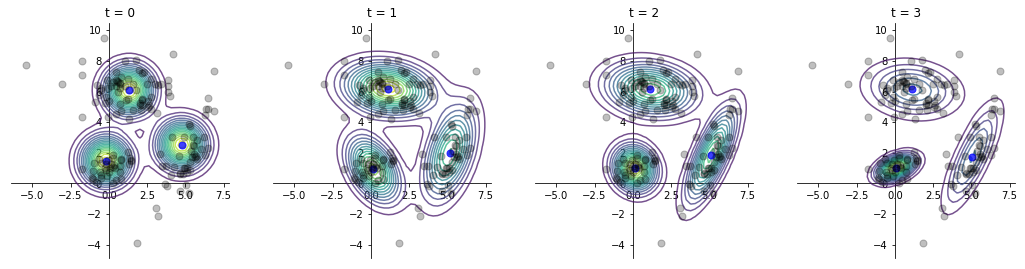

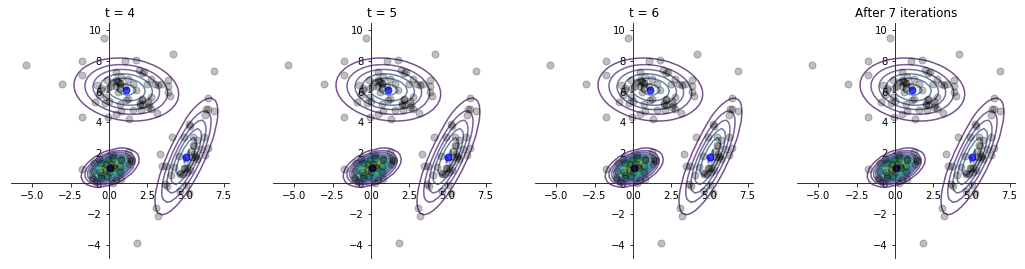

In [11]:
n_iter = 7; n_cols = 4; M_start = np.array([[1.33, 6.09], [-0.19, 1.48], [4.77, 2.53]])
gmm_expectation_maximization(X, n_iter, M_start, partial(plot_em_state, n_cols));

## Visualization of the progress per E-Step, M-Step and per component

In [12]:
def plot_intermediate_em_state(k, 
                               state, t, i, Z, w, M, S):

    global axs
    
    if state == 'E-Step i':
        if i == 0: axs = init_plots(k+1, lims, title=
            'Iteration '+str(t+1)+',   E-Step a):   ' +
            'How likely are the data points with respect to the GMM components ' +
            '$\mathcal{w}_i \: \mathcal{N}(x_j \mid \mu_i,\, \Sigma_i)$?')
        
        axs[i].set_title(
            '$\zeta_{#j} := \mathcal{w}_# \: \mathcal{N}(x_j \mid \mu_#,\, \Sigma_#)$'.replace('#', str(i+1)), 
            fontsize='x-large')
        
        plot_model(axs[i], (xs, ys, w[i] * gaussian_pdf(xys, M[i], S[i])), alpha=0.1)
        plot_data(axs[i], X, Z[i], alpha=0.5)
        
        if i == k-1: 
            axs[k].set_title('$\Sigma_{i=1}^k \zeta_{ij}$', fontsize='x-large')
            plot_model(axs[k], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)), alpha=0.1)
            plot_data(axs[k], X, np.sum(Z, axis=0), alpha=0.5, scale=True)
            done_plots()
        
    elif state == 'E-Step k':
        
        axs = init_plots(k+1, lims, title=
            'Iteration '+str(t+1)+',   E-Step b):   ' + 
            'Normalize the likelihoods, so that each $x_{j}$ is for sure the result of some component!')
        
        for i in range(k):
            axs[i].set_title(
                ('$\zeta_{#j} := \zeta_{#j} \:/\:( \Sigma_{l=1}^k \mathcal{w}_l \: ' + 
                '\mathcal{N}( x_j\mid \mu_l,\, \Sigma_l))$').replace('#', str(i+1)), fontsize='x-large')
            
            plot_model(axs[i], (xs, ys, w[i] * gaussian_pdf(xys, M[i], S[i])), alpha=0.1)
            plot_data(axs[i], X, Z[i], alpha=0.5)
            
        axs[k].set_title('$\Sigma_{i=1}^k \zeta_{ij} \equiv 1$', fontsize='x-large')
        plot_model(axs[k], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)), alpha=0.1)
        plot_data(axs[k], X, np.sum(Z, axis=0), alpha=0.5, scale=True)
        done_plots()
        
    elif state == 'M-Step i':
        if i == 0: axs = init_plots(k+1, lims, title=
            'Iteration '+str(t+1)+',   M-Step:   Optimize the component parameters ' +
            '$\mu_i = (\Sigma_{j} \zeta_{ij} x_j)/(\Sigma_{j} \zeta_{ij})$, ' +
            '$\Sigma_i = (\Sigma_{j} \zeta_{ij} (x_j - \mu_i)(x_j - \mu_i)^T)/(\Sigma_{j} \zeta_{ij})$, ' +
            '$\mathcal{w}_i  = (\Sigma_{j} \zeta_{ij})/n$!')
        
        axs[i].set_title(
            'Optimize $w_#,\mu_#,\Sigma_#$ given all $\zeta_{ij}$'.replace('#', str(i+1)), fontsize='x-large')
        
        plot_means(axs[i], np.array([M[i]]))
        plot_model(axs[i], (xs, ys, w[i] * gaussian_pdf(xys, M[i], S[i])))
        plot_data(axs[i], X, Z[i], alpha=0.2)
        
        if i == k-1: 
            axs[k].set_title('Best explanation of $x_{j}$ and $\zeta_{ij}$'.replace('#', str(i+1)), fontsize='x-large')
            plot_means(axs[k], M)
            plot_model(axs[k], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)))
            plot_data(axs[k], X, np.sum(Z, axis=0), alpha=0.2)
            done_plots()

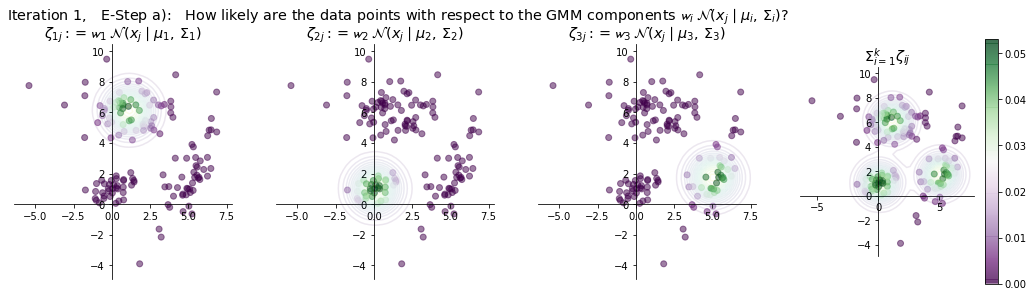

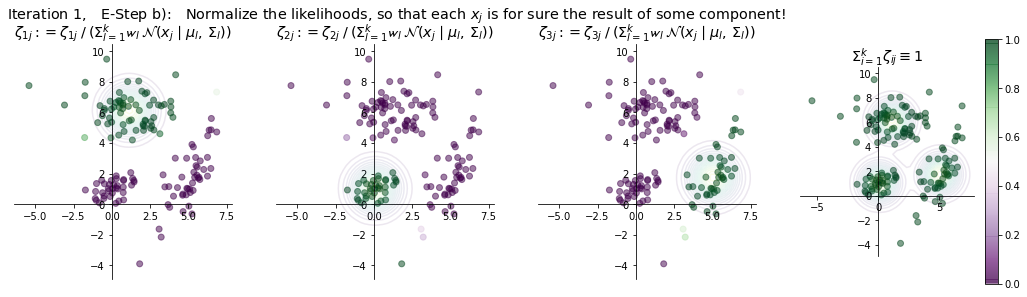

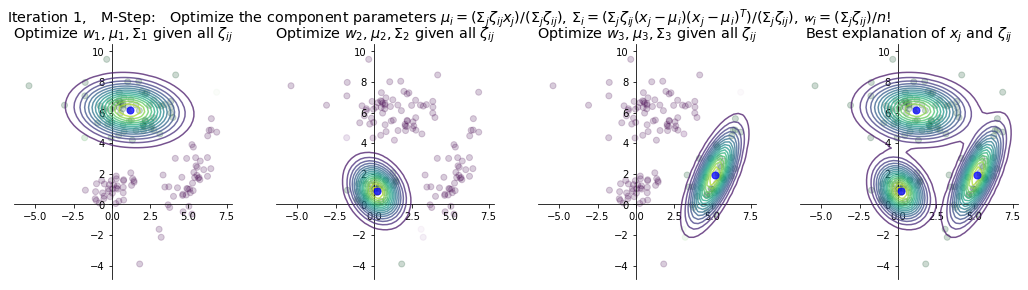

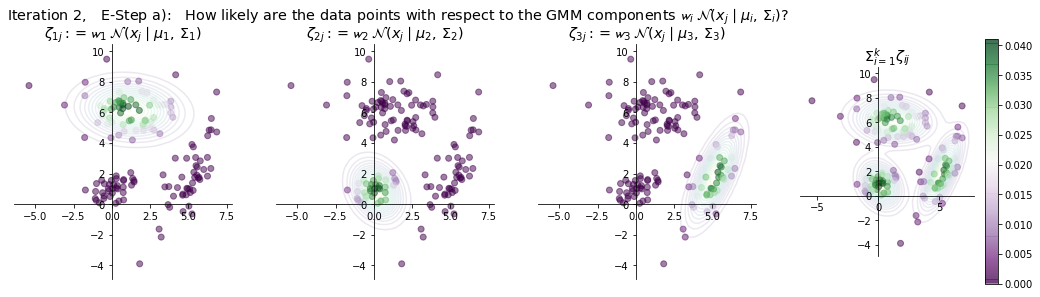

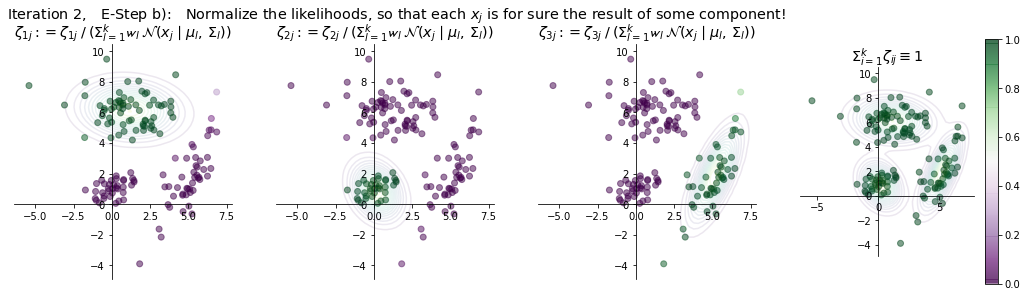

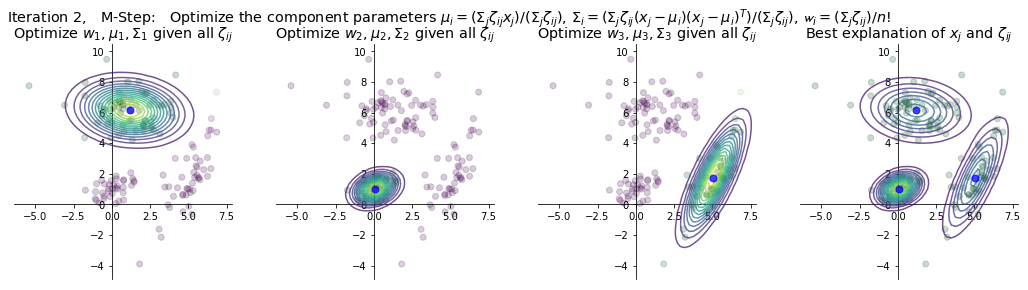

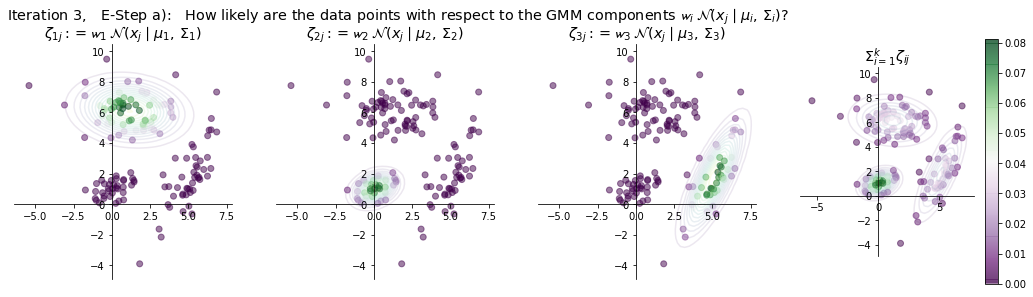

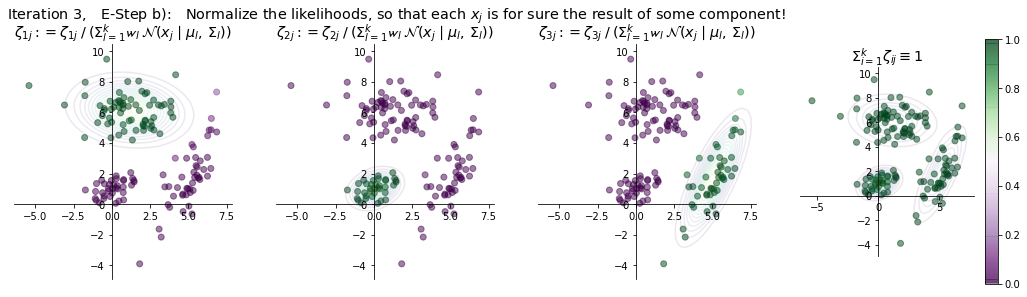

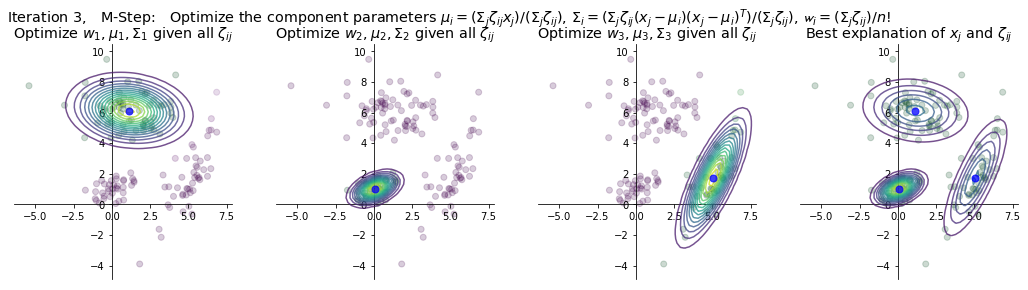

In [13]:
n_iter = 3; k = 3
gmm_expectation_maximization(X, n_iter, M_start, partial(plot_intermediate_em_state, k));

## Sample distributions

In [14]:
def pds_matrix(phi, l1, l2):
    cc = np.cos(phi)**2; ss = np.sin(phi)**2; cs = np.cos(phi)*np.sin(phi)
    return np.array([[l1*cc + l2*ss, (l1-l2)*cs], [(l1-l2)*cs, l1*ss +l2*cc]])

In [15]:
xmin, xmax = -3.0, +3.0
ymin, ymax = -3.0, +3.0
lims = [xmin, xmax, ymin, ymax]
xs, ys, xys = grid_and_points(lims)

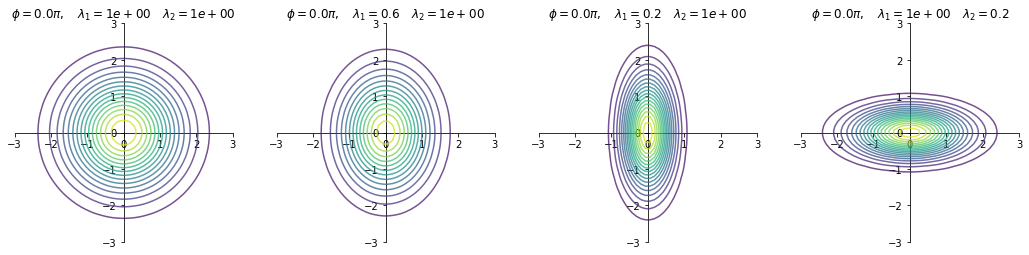

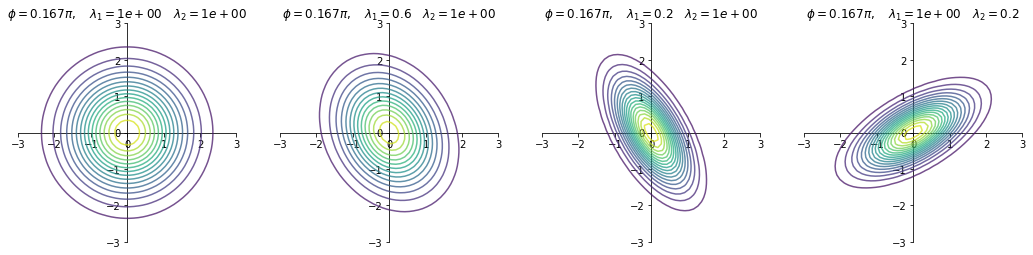

In [16]:
phis = [0., np.pi/6]
eigenvalues = [(1., 1.), (.6, 1.), (.2, 1.), (1., .2)]
for phi in phis:
    axs = init_plots(len(eigenvalues), lims)
    for a, (l1, l2) in zip(axs, eigenvalues):
        a.set_title('$\phi={:.3}\pi,\quad\lambda_1={:3.1}\quad\lambda_2 ={:.1}$'.format(phi/np.pi, l1, l2))
        plot_model(a, (xs, ys, gaussian_pdf(xys, np.zeros(2), pds_matrix(phi, l1, l2))))
    done_plots()

In [17]:
def gaussians_in_a_circle(k, R, l1, l2):
    phis = 2*np.pi * np.array(list(range(k))) / k
    ws = np.ones(k) / k
    Ms = np.array([[np.cos(phi), np.sin(phi)] for phi in phis]) * R
    Ss = np.array([pds_matrix(phi, l1, l2) for phi in phis])
    return ws, Ms, Ss

def gaussians_in_a_line(xs, phi, l1, l2):
    k = len(xs)
    ws = np.ones(k) / k
    Ms = np.array([[x, 0] for x in xs])
    Ss = np.tile(pds_matrix(phi, l1, l2), (3, 1, 1))
    return ws, Ms, Ss

In [18]:
standard_gaussian = (np.array([1.]), np.array([np.zeros(2)]), np.array([np.identity(2)]))
two_gaussians     = gaussians_in_a_circle(2, 2., .5,  .5)
almost_a_triangle = gaussians_in_a_circle(3, 2., .05, 2.)
little_flower     = gaussians_in_a_circle(4, 2.5, .8,  .2)
three_in_a_row    = gaussians_in_a_line([-2, 0, +2], np.pi/4, 1., .05)

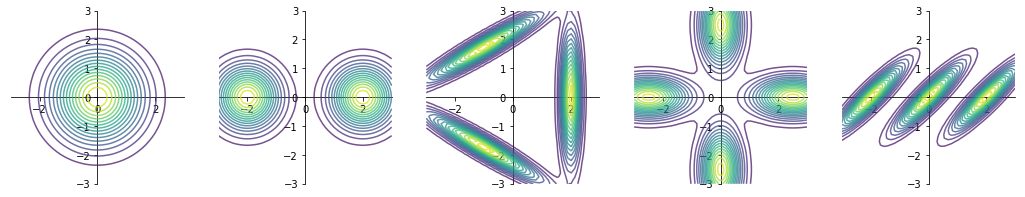

In [19]:
axs = init_plots(5, lims)
for a, parameters in zip(axs, [standard_gaussian, two_gaussians, almost_a_triangle, little_flower, three_in_a_row]):
    ws, Ms, Ss = parameters
    plot_model(a, (xs, ys, gaussian_mixture_pdf(xys, ws, Ms, Ss)))
done_plots()

# Playground

In [20]:
def MacQueen(X, k):
    n, m = X.shape
    M = np.copy(X[:k])
    N = np.ones(k)
    for j in range(k, n):
        i = np.argmin(np.sum((M - X[j])**2, axis=1))
        N[i] += 1
        M[i] += 1./N[i] * (X[j] - M[i])
    return M

In the previous notebook we gave you examples, that illustrated that the EM-Algorithm might

  * lead to suboptimal results, for some "bad" intialization.
  * lead to good results, for certain "good" initialization.
  * will fit any model, reasonable or not.

You might want to review these cases to understand, what we mean by "suboptimal" or "reasonable" result. You might wander whether it was easy for us to find "good" and "bad" intializations and whether the given mixture was chosen with specific intentions.

In the next cell you find code that you may use to explore the properties of the algorithm. How easy is it to find "good" initializations? How is the **quality of the result** and the **speed of the algorithm** impacted by

  * the position of the initial centers,
  * the number of initial centers,
  * the overall shape of the Gaussian mixture, and
  * the sample size?


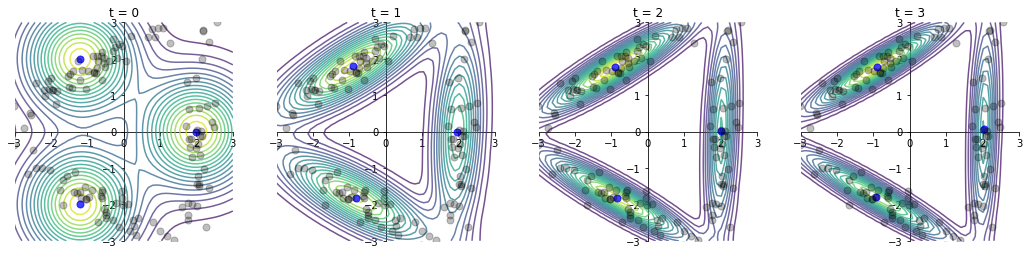

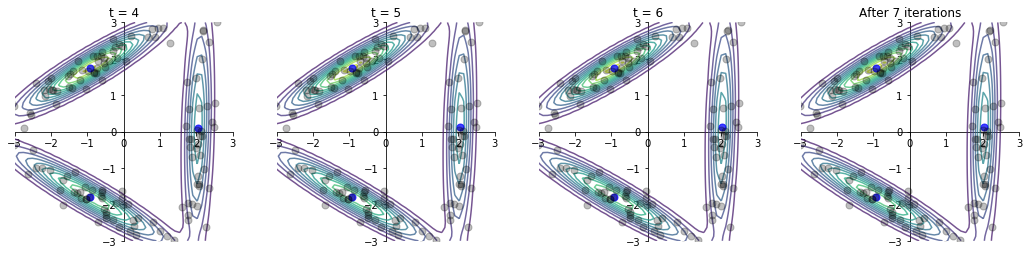

In [21]:
# Defined above: standard_gaussian, two_gaussians, almost_a_triangle, little_flower, three_in_a_row   
ws, Ms, Ss = almost_a_triangle

X = gaussian_mixture_sample(ws, Ms, Ss, 150) # Explore the effect of the sample size

M_start = np.array([[2, 0], [-1.2, 2], [-1.2, -2]]) # Explore the effect of the initialization by hand or ...
# M_start = MacQueen(X, 3)                          # ... with MacQueens k-means

w, M, S = gmm_expectation_maximization(X, 7, M_start, show=partial(plot_em_state, 4))              # See a bit or ...
# w, M, S = gmm_expectation_maximization(X, 3, M_start, show=partial(plot_intermediate_em_state, len(M_start))) # ... all

## Challenges

What did you find out about the algorithm? Here are some challenges for you. Not all are necessarily solveable. If you are not sure, you might want to revisit the slides. When experimentation leaves you puzzeled, theory might shed some light on the situation. Here is the code from above. Use it to start your search:

```
#Defined above: standard_gaussian, two_gaussians, almost_a_triangle, little_flower, three_in_a_row   
ws, Ms, Ss = almost_a_triangle

X = gaussian_mixture_sample(ws, Ms, Ss, 150)

M_start = np.array([[2, 0], [-1.2, 2], [-1.2, -2]])
#M_start = MacQueen(X, 3)                          

w, M, S = gmm_expectation_maximization(X, 7, M_start, show=partial(plot_em_state, 4))              # See a bit or ...
#w, M, S = gmm_expectation_maximization(X, 3, M_start, show=partial(plot_intermediate_em_state, len(M_start))) # all
```

### 1) Find a setup that lead to particulary bad result
Choose a distribution and an intialization, that leads to a bad result. What are easy ways to sabotage success? Why does the algorithm "fail"? What does this tell you about promissing setups?

### 2) Are you able to lead the algorithm to a bad result for the standard Gaussian?

If yes, how? If no, why?

In [22]:
ws, Ms, Ss = standard_gaussian


### 3) Find an setup that leads to a good result, but very slowly.
All examples that we showed you either lead to a good or a bad result, but both in only a few iterations. Is it possible that the algorithm iterates more often and still finds a good result? Give us an example.

### 4) Are you able to find a setup so that the algorithm loops?
If it is possible to have slow progress, it might be possible to create loops so that the algorithm is in exactly the same state after a few steps as it was before. What ideas do you have? Is it possible? If yes, how? If no, why?

### 5) Find a distribution for which even k-means intialization does not give good results. 
Our recipe for finding good intializations was to use MacQueen's k-means. Are there any Gaussian mixtures, for which even the initilization with k-means does not help? What are the properties of such Gaussian mixtures that lead to the failure of the algorithm?

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; D. Speicher, C. Bauckhage<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>